In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from scipy.stats import norm
import matplotlib.image as matimg
import glob

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives

In [11]:
num_training_examples = 1200
num_testing_examples = 125

batch_size = 25
original_dim = 12288 #this is same as image_vector_size
latent_dim = 2
intermediate_dim = 256
nb_epoch = 50
epsilon_std = 1.0

In [12]:
def load_image(path):
    img = matimg.imread(path)
    return img

#following code loads data from local repo
#directory should have two subfolders, with name train and test
def load_local_data(path):
    paths = glob.glob(os.path.join(path + "/train", "*.jpg"))
    X_train = np.array( [ load_image(p) for p in paths ] )

    paths = glob.glob(os.path.join(path + "/test", "*.jpg"))
    X_test = np.array( [ load_image(p) for p in paths ] )
   
    return X_train, X_test

In [13]:
#building model
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [16]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [17]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [18]:
# modified calculation of loss
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [19]:
# vae model
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

# if want to train with data from local repo
path="newyorkB"
(x_train, x_test) = load_local_data(path)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#to train the model

vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

#vae.save_weights('vae_landscape_100.h5')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1200 samples, validate on 125 samples
Epoch 1/50
1200/1200 [==============================] - 3s 3ms/step - loss: 7575.9607 - val_loss: 6869.2327
Epoch 2/50
1200/1200 [==============================] - 3s 2ms/step - loss: 6798.7385 - val_loss: 6720.6233
Epoch 3/50
1200/1200 [==============================] - 3s 2ms/step - loss: 6703.6304 - val_loss: 6606.9116
Epoch 4/50
1200/1200 [==============================] - 3s 2ms/step - loss: 6496.6377 - val_loss: 6814.9846
Epoch 5/50
1200/1200 [==============================] - 3s 2ms/step - loss: 6466.8255 - val_loss: 6610.6896
Epoch 6/50
1200/1200 [==============================] - 3s 2ms/step - loss: 6438.9527 - val_loss: 6534.4039
Epoch 7/50
1200/1200 [==============================] - 3s 2ms/step - loss: 6412.2679 - val_loss: 6527.8062
Epoch 8/50
1200/1200 [==============================] - 3s 2ms/step - loss: 6382.2238 - val_loss: 6448.3594
Epoch 9/50
1200/1200 [==============================] - 3s 2ms/step - loss: 6366.6971 - v

In [21]:
#to load the already trained model weights
#vae.load_weights('vae_landscape_100.h5')

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

# build a face generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

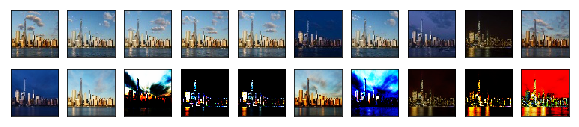

In [24]:
# display a 2D manifold of the faces
face_size = 64
#figure = np.zeros((face_size * n, face_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian


# following values can generate some good skyline images
samples_encoded = [[5.55, -3.33], [-1.11, 10], [120, 13.3], [33.33, -77.77], [11.11, -33.33], [11.11, 11.11], [100, -33.33], [-7.77, -1.11], [-33.33, -11.11], [-33.33, 11.11]]
samples = x_test[15:25]
# code to create a result.png with generated faces
plt.figure(figsize=(10, 2))

for i, yi in enumerate(samples_encoded):
    z_sample = np.array([[yi[0], yi[1]]])
    x_decoded = generator.predict(z_sample)
    x_decoded = x_decoded
    #print x_decoded.shape
    face = x_decoded[0].reshape(face_size, face_size, 3)


    ax1 = plt.subplot(2, 10, i + 1)
    plt.imshow(samples[i].reshape(face_size, face_size, 3))
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 10 + 1)
    plt.imshow(face)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



plt.savefig('result.png')
#plt.show()